<div style="float:left">
    <h1 style="width:500px">Live Coding 8: Dimensions in Data</h1>
    <h2 style="width:450px">Dealing with high-dimensional spaces</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

- BibTeX file!
  - Still owe you this!
- Assessment #2 and #3.
  - Group assignments complete.
  - Models for policy briefings
  - Proposal outline form
  - Next two live sessions focus on this
  - Making Group Work 'Work' email.
- Readings

## Preamble

In [1]:
fn  = '2022-09-10-listings.geofeather'

Standard libraries we've seen before.

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import math
import matplotlib.pyplot as plt

Vectorisers we will use from the 'big beast' of Python machine learning: Sci-Kit Learn.

In [3]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

NLP-specific libraries that we will use for tokenisation, lemmatisation, and frequency analysis.

In [4]:
import nltk
import spacy
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

Remaining libraries that we'll use for processing and display text data. Most of this relates to dealing with the various ways that text data cleaning is *hard* because of the myriad formats it comes in.

In [5]:
import seaborn as sns

## The Curse of Dimensionality

In [6]:
distances = {}

ndist = 3000
ndims = 7

x = np.arange(1,ndist)

for y in range(1,ndims):
    distance = np.zeros(ndist,float)
    print(f"Exponent: {y}")
    for j in x:
        #print(f"x: {j}; y: {y}")
        #print(np.sum(np.repeat(y, j)**2)**(1/2))
        distance[j] = np.sum(np.repeat(y, j)**2)**(1/2)
    distances[f"$d$={y}"] = distance

Exponent: 1
Exponent: 2
Exponent: 3
Exponent: 4
Exponent: 5
Exponent: 6


In [7]:
df = pd.DataFrame(distances)
df.head()

,$d$=1,$d$=2,$d$=3,$d$=4,$d$=5,$d$=6
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000
2,1.414214,2.828427,4.242641,5.656854,7.071068,8.485281
3,1.732051,3.464102,5.196152,6.928203,8.660254,10.392305
4,2.000000,4.000000,6.000000,8.000000,10.000000,12.000000


In [8]:
mdf = df.reset_index().melt(id_vars=['index'])
mdf.columns = ['x', 'Inter-observation Distance', 'Euclidean Distance']

In [9]:
mdf.head()

,x,Inter-observation Distance,Euclidean Distance
0,0,$d$=1,0.000000
1,1,$d$=1,1.000000
2,2,$d$=1,1.414214
3,3,$d$=1,1.732051
4,4,$d$=1,2.000000


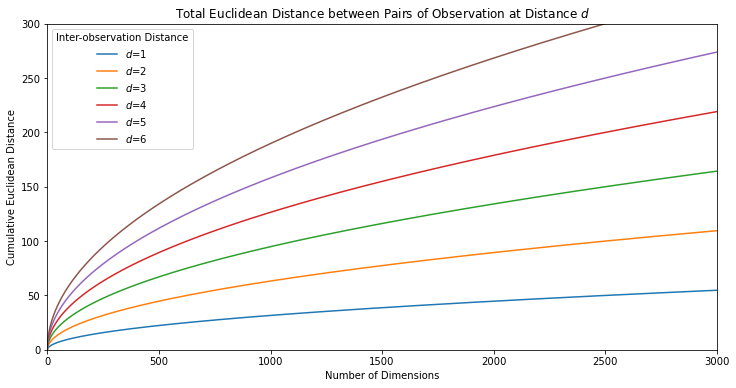

In [10]:
f,ax = plt.subplots(1,1,figsize=(12,6))
sns.lineplot(data=mdf, x='x', hue='Inter-observation Distance', y='Euclidean Distance', ax=ax)
ax.set_xlim([0,3000])
ax.set_ylim([0,300])
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Euclidean Distance");
plt.title("Total Euclidean Distance between Pairs of Observation at Distance $d$");

## Word2Vec

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from textual import *

In [ ]:
gdf = gpd.read_feather(os.path.join('data','geo',fn)).set_index('id')

This takes about **11 minutes**.

In [ ]:
%%time 
gdf['description_norm'] = gdf.description.apply(normalise_document, remove_digits=True, special_char_removal=True)

In [ ]:
gdf.to_feather(os.path.join('data',fn))

In [ ]:
from gensim.models.word2vec import Word2Vec

In [ ]:
dims = 100
print(f"You've chosen {dims} dimensions.")

window = 3
print(f"You've chosen a window of size {window}.")

min_v_freq  = 0.005 # Don't keep words appearing less than 0.5% frequency
min_v_count = math.ceil(min_v_freq * gdf.shape[0])
print(f"With a minimum frequency of {min_v_freq*100:.2f}% and {gdf.shape[0]:,} documents, minimum vocab frequency is {min_v_count:,}.")


This will take about **12 minutes**.

In [ ]:
gdf['tokens'] = gdf.description_norm.apply(lambda x: [y for y in x.split(' ') if y != '.'])

In [ ]:
%%time 

#corpus      = gdf.description_norm.fillna(' ').values
#corpus_sent = [d.replace('.',' ').split(' ') for d in corpus] # <-- deals better with many short sentences though context may end up... weird
model       = Word2Vec(sentences=gdf.tokens, vector_size=dims, window=window, epochs=200, 
                 min_count=min_v_count, seed=42, workers=1)

model.save(f"word2vec-d{dims}-w{window}.model") # <-- You can then Word2Vec.load(...) which is useful with large corpora

In [ ]:
def vlkp(w:str, m:Word2Vec) -> np.ndarray:
    try:
        return m.wv[w]
    except KeyError:
        return np.nan
    
def avg_embedding(t:list, m:Word2Vec):
    vecs = [y for y in [vlkp(x, model) for x in t if x != -1] if not np.isnan(y).all()]
    if len(vecs)==0:
        return np.nan
    else:
        return np.mean(np.stack(vecs, axis=0), axis=0)

In [ ]:
gdf[f'doc_vec'] = gdf.tokens.apply(avg_embedding, args=(model,))

In [ ]:
problematic_gdf = gdf[gdf.doc_vec.isna()].copy()

In [ ]:
gdf = gdf[~gdf.doc_vec.isna()]

In [ ]:
fn

In [ ]:
gdf.to_feather( os.path.join('data',fn.replace('-listings','-listings-embedded')) )

## Dimensionality Reduction

In [11]:
gdf = gpd.read_feather( os.path.join('data',fn.replace('-listings','-listings-embedded')) )

In [12]:
import umap

In [13]:
def x_from_df(df:pd.DataFrame, col:str='Embedding') -> pd.DataFrame:
    cols = ['d'+str(x) for x in np.arange(0,len(df[col].iloc[0]))]
    return pd.DataFrame(df[col].tolist(), columns=cols, index=df.index)

X = x_from_df(gdf, col='doc_vec')

In [17]:
gdf.doc_vec.iloc[0]

array([ 1.1261873e-01,  6.8764098e-02, -2.6351202e-01, -1.1569644e-01,
        1.2024078e-01,  1.8054511e-01, -1.8766069e-01, -3.9689463e-01,
       -1.3671950e-01,  5.9132141e-01, -1.7524666e-01,  1.7180033e-01,
        3.3868557e-01, -1.8213971e-01,  5.6799185e-01,  1.9219835e-01,
       -3.3649510e-01, -5.2977365e-01, -2.1651997e-01,  1.4145079e-01,
       -2.1501951e-01,  5.7986522e-01, -1.6774166e-01,  1.8267220e-01,
       -3.8740826e-01,  1.9285700e-01, -3.4377170e-01, -1.8080558e-01,
       -2.1307354e-01, -5.7977659e-01,  1.6121060e-01, -2.5270694e-01,
        7.7997856e-02,  6.0538976e-03, -1.5013077e-02, -4.6640357e-01,
        3.7728760e-01, -1.7583922e-01,  1.1705812e-01,  1.3875590e-01,
        5.2300976e-07,  6.4408946e-01, -1.3168152e-01, -5.1523352e-01,
        3.3915472e-01,  6.7100304e-01,  1.5671046e-01,  8.9400839e-03,
       -4.5268884e-01, -1.0270672e+00,  4.4619378e-01,  9.7973779e-02,
        2.7174562e-01, -8.5875183e-02,  1.6234781e-01, -4.5848332e-02,
      

In [18]:
%%time

reducer = umap.UMAP(
        n_neighbors=25,
        min_dist=0.01,
        n_components=2,
        random_state=42)
    
# Basically reduces our feature vectors for each thesis, down to n dimensions
X_embedded = reducer.fit_transform(X)
    

CPU times: user 1min 56s, sys: 9.35 s, total: 2min 5s
Wall time: 1min 26s


The above will take about **2 minutes**.

In [19]:
embedded_dict = {}
for i in range(0,X_embedded.shape[1]):
    embedded_dict[f"V{i+1}"] = X_embedded[:,i]

# dfe == df embedded
dfe = pd.DataFrame(embedded_dict, index=gdf.index)
del(embedded_dict)

In [20]:
projected = dfe.join(gdf)
print(projected.columns.values)

['V1' 'V2' 'index' 'listing_url' 'last_scraped' 'name' 'description'
 'host_id' 'host_name' 'host_since' 'host_location' 'host_is_superhost'
 'host_listings_count' 'host_total_listings_count' 'host_verifications'
 'latitude' 'longitude' 'property_type' 'room_type' 'accommodates'
 'bathrooms_text' 'bedrooms' 'beds' 'amenities' 'price' 'minimum_nights'
 'maximum_nights' 'availability_365' 'number_of_reviews' 'first_review'
 'last_review' 'review_scores_rating' 'reviews_per_month' 'geometry'
 'description_norm' 'doc_vec' 'tokens']


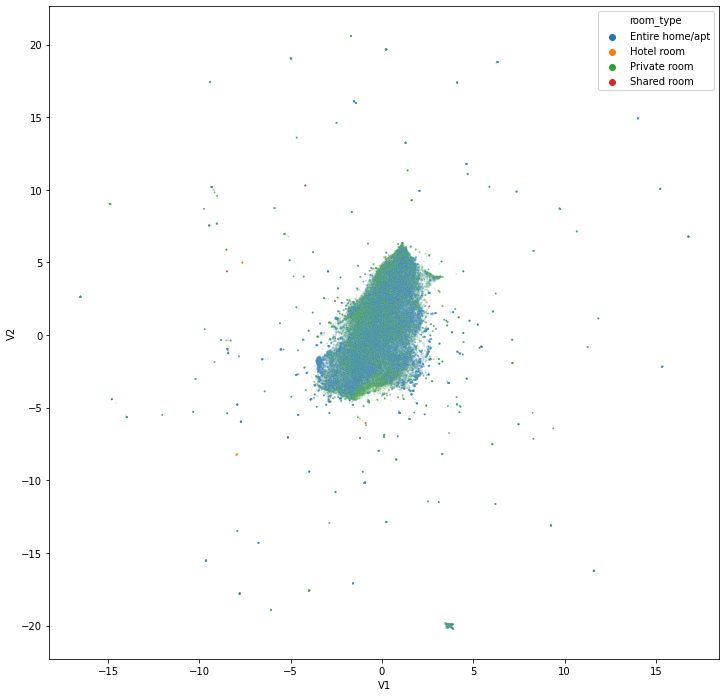

In [21]:
f,ax = plt.subplots(1,1,figsize=(12,12))
sns.scatterplot(data=projected, x='V1', y='V2', hue='room_type', s=3, alpha=0.2, ax=ax);
#ax.axis('off')

(61245, 37)


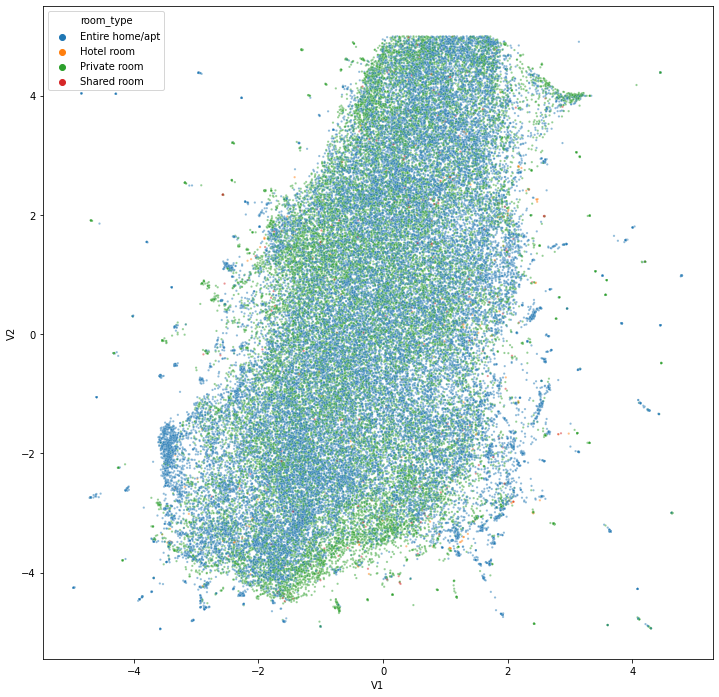

In [22]:
sample = projected[(projected.V1.between(-5,5)) & (projected.V2.between(-5,5))]
f,ax = plt.subplots(1,1,figsize=(12,12))
sns.scatterplot(data=sample, x='V1', y='V2', hue='room_type', s=5, alpha=0.5, ax=ax);
print(sample.shape)

## Select Sample

In [47]:
selected = projected[projected.room_type=='Hotel room'].copy()
#selected = projected[projected.price > 250].copy()
print(f"Selected {selected.shape[0]:,} records.")

Selected 231 records.


(231, 37)
id
25041758    [provide, excellent, self, catering, service, ...
29726669    [space, europ, cuttingedge, luxury, hideaway, ...
22750548    [provide, excellent, self, catering, service, ...
34662899    [lively, hammersmith, hostel, locate, across, ...
31732672    [provide, excellent, self, catering, service, ...
Name: tokens, dtype: object


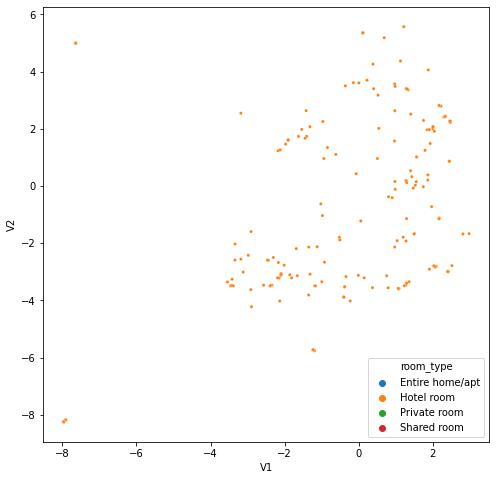

In [48]:
f,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=selected, x='V1', y='V2', hue='room_type', s=10, ax=ax);
print(selected.shape)
print(selected.tokens.sample(5))

## DBSCAN

In [49]:
from sklearn.cluster import DBSCAN

In [50]:
cols = [x for x in selected.columns.to_list() if x.startswith('V')]
clust = DBSCAN(eps=.5, min_samples=3, metric='euclidean').fit(selected[cols])
selected['dbscan'] = clust.labels_
print(f"Have {len(selected.dbscan.unique())} clusters (including outliers)")

Have 17 clusters (including outliers)


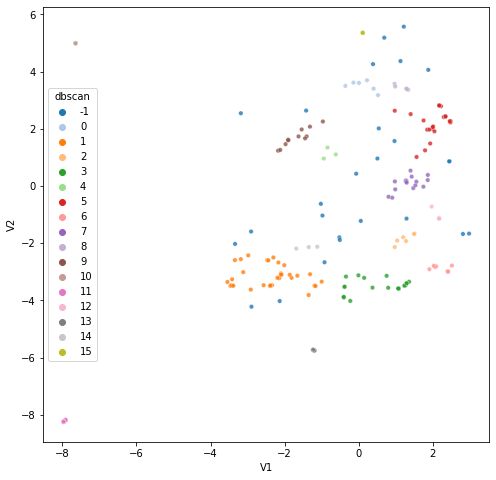

In [51]:
f,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=selected, x='V1', y='V2', hue='dbscan', 
                palette=sns.color_palette('tab20')[:len(selected.dbscan.unique())],
                alpha=0.8, s=20, ax=ax);

In [52]:
pd.DataFrame({'Cluster':selected.dbscan.value_counts().sort_index()})

,Cluster
-1,26
0,6
1,38
2,6
3,23
4,3
5,25
6,11
7,16
8,5


In [53]:
selected[selected.dbscan==10][['host_name','tokens']]

,host_name,tokens
id,,
20405481,Capital Residencies,"[large, studio, apartment, londo, exclusive, n..."
22102228,Capital Residencies,"[good, size, studio, londo, exclusive, neighbo..."
22102335,Capital Residencies,"[spacious, studio, apartment, londo, exclusive..."
22786332,Capital Residencies,"[studio, londo, exclusive, neighbourhood, clos..."
22787197,Capital Residencies,"[spacious, studio, apartment, londo, exclusive..."
22791853,Capital Residencies,"[good, size, studio, londo, exclusive, neighbo..."
22792498,Capital Residencies,"[good, size, studio, londo, exclusive, neighbo..."
22793419,Capital Residencies,"[good, size, studio, apartment, londo, exclusi..."
25041408,Capital Residencies,"[good, size, studio, apartment, londo, exclusi..."


Cluster -1
  26 observations across 20 hosts.
  Median host listings count is 1.0


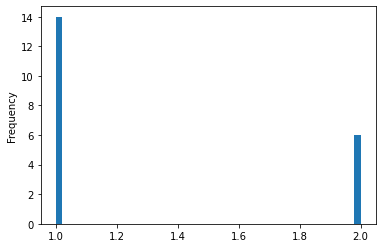


Cluster 0
  6 observations across 5 hosts.
  Median host listings count is 1.0


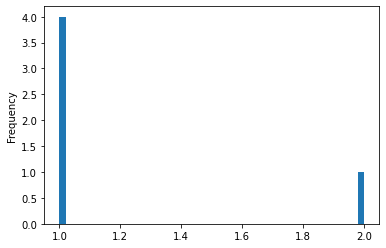


Cluster 1
  38 observations across 9 hosts.
  Median host listings count is 1.0


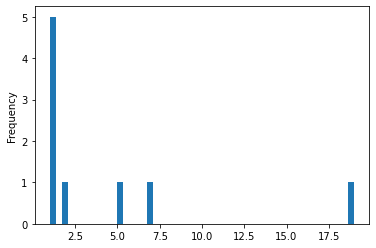


Cluster 2
  6 observations across 3 hosts.
  Median host listings count is 2.0


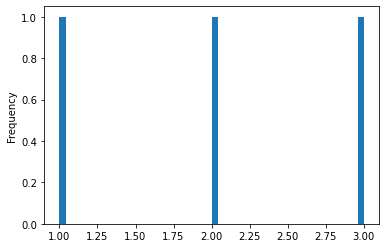


Cluster 3
  23 observations across 9 hosts.
  Median host listings count is 1.0


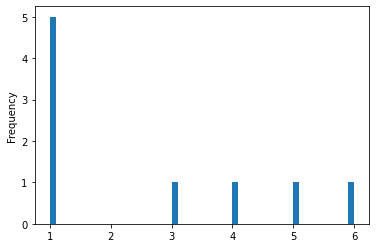


Cluster 14
  3 observations across 3 hosts.
  Median host listings count is 1.0


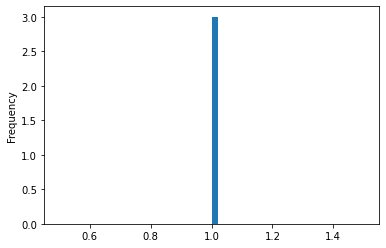


Cluster 4
  3 observations across 2 hosts.
  Median host listings count is 1.5


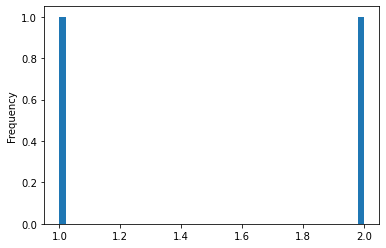


Cluster 5
  25 observations across 5 hosts.
  Median host listings count is 4.0


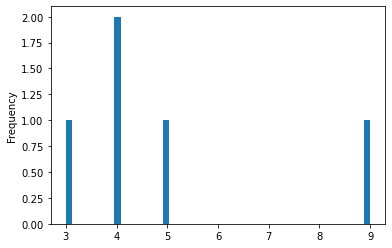


Cluster 6
  11 observations across 4 hosts.
  Median host listings count is 2.0


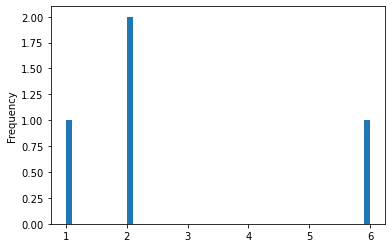


Cluster 7
  16 observations across 6 hosts.
  Median host listings count is 2.0


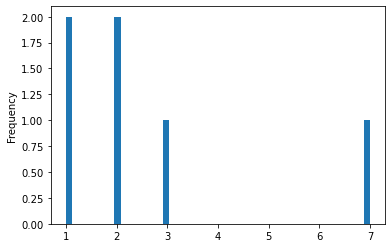


Cluster 8
  5 observations across 2 hosts.
  Median host listings count is 2.5


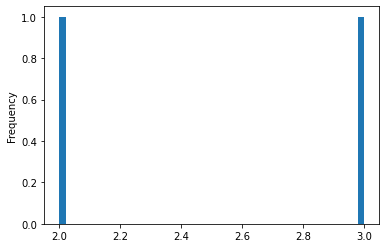


Cluster 9
  12 observations across 5 hosts.
  Median host listings count is 1.0


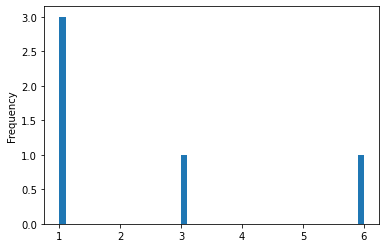


Cluster 10
  20 observations across 1 hosts.
  Median host listings count is 20.0


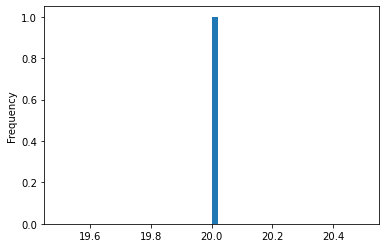


Cluster 11
  23 observations across 1 hosts.
  Median host listings count is 23.0


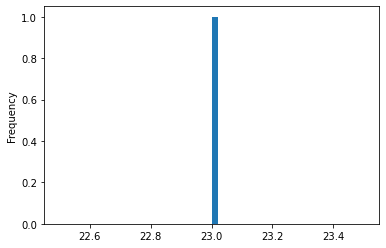


Cluster 12
  4 observations across 2 hosts.
  Median host listings count is 2.0


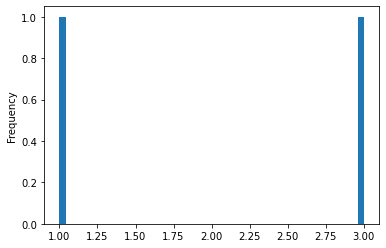


Cluster 13
  5 observations across 1 hosts.
  Median host listings count is 5.0


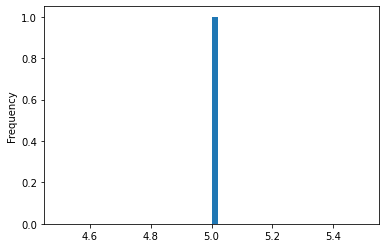


Cluster 15
  5 observations across 1 hosts.
  Median host listings count is 5.0


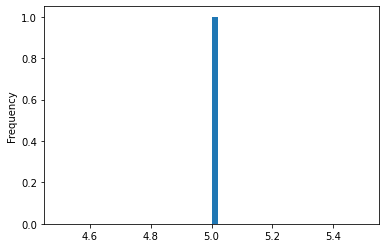

In [54]:
for c in selected.dbscan.unique():
    clust = selected[selected.dbscan==c]
    print(f"Cluster {c}")
    print(f"  {clust.shape[0]:,} observations across {len(clust.host_name.unique())} hosts.")
    print(f"  Median host listings count is {clust.groupby(by='host_name')['V1'].agg('count').median()}")
    clust.groupby(by='host_name')['V1'].agg('count').plot.hist(bins=50)
    plt.show()
    print()

## HAC

In [55]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, centroid
from scipy.spatial import distance
from scipy.spatial.distance import pdist

from sklearn.metrics import silhouette_score, silhouette_samples

from math import floor

In [56]:
%%time
dmeasure = 'euclidean'

print(f"Clustering using {dmeasure} metric on {len(cols)} dims...")
# Note that Ward's method required a Euclidean metric
# For other metrics the 'centroid' method looks best
if dmeasure == 'euclidean':
    pass
    Z = linkage(selected[cols], method='ward', metric=dmeasure)
else:
    pass
    Z = linkage(selected[cols], metric=dmeasure)

Clustering using euclidean metric on 2 dims...
CPU times: user 5.3 ms, sys: 1.19 ms, total: 6.5 ms
Wall time: 4.27 ms


Showing last 46 clusters


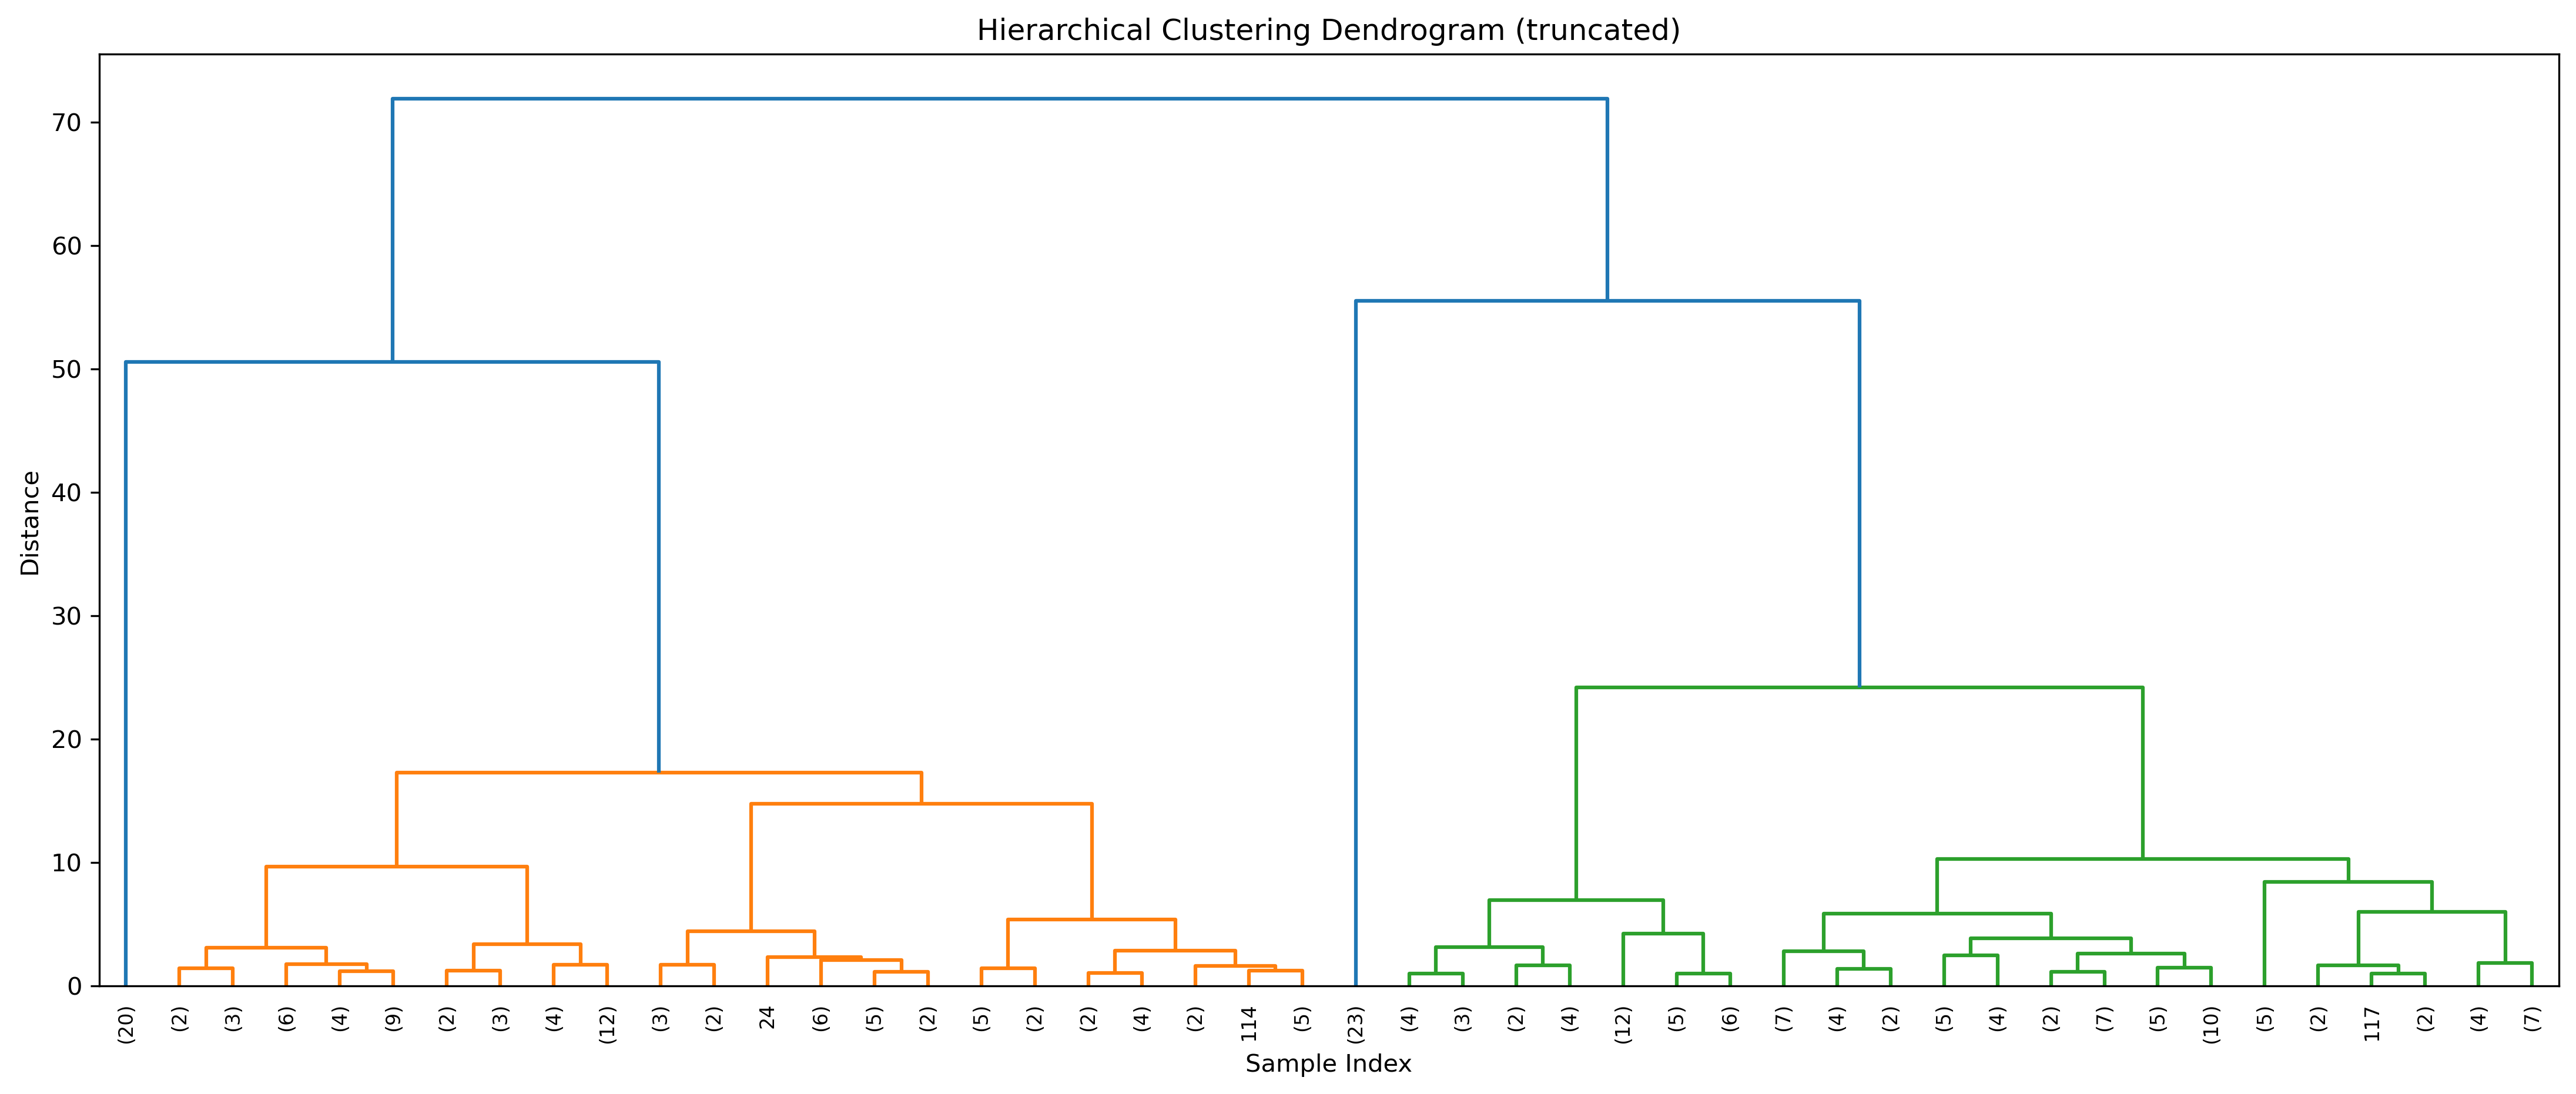

In [57]:
last_cls = 100 if selected.shape[0] > 300 else floor(selected.shape[0]*0.2) # The number of last clusters to show in the dendogram
print(f"Showing last {last_cls} clusters")

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
fig = plt.gcf()
fig.set_size_inches(18, 7)
fig.set_dpi(300)
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=last_cls,             # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=False,  # to get a distribution impression in truncated branches
)
plt.show()

In [58]:
start_cl = 2
end_cl   = 50

sil_scores = []

print("Scoring cluster levels: ", end="")

for i in range(start_cl,end_cl):
    print(".", end="")
    clusterings = fcluster(Z, i, criterion='maxclust')
    
    # Calculate silhouett average
    sil_avg = silhouette_score(selected[cols], clusterings)
    
    # Append silhouette scores
    sil_scores.append(sil_avg)

print("\nDone.")

Scoring cluster levels: ................................................
Done.


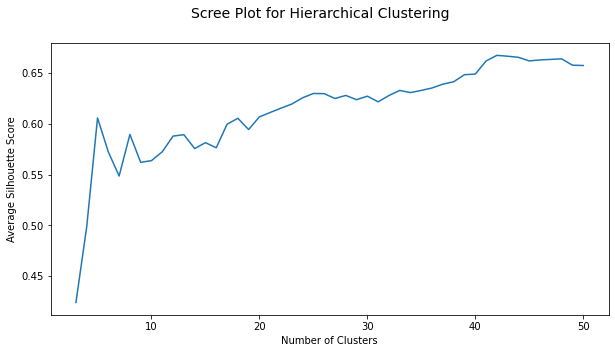

In [59]:
fig,ax = plt.subplots(1,1,figsize=(10,5));
sns.lineplot(x=np.arange(3,3+len(sil_scores)), y=sil_scores, ax=ax)
ax.set_title("")
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Average Silhouette Score")

plt.suptitle(f"Scree Plot for Hierarchical Clustering", fontsize=14);

plt.show();

In [60]:
num_clusters = 5
criterion    = 'maxclust'
cut = fcluster(Z, num_clusters, criterion=criterion)

In [61]:
selected['HAC_Cluster'] = cut

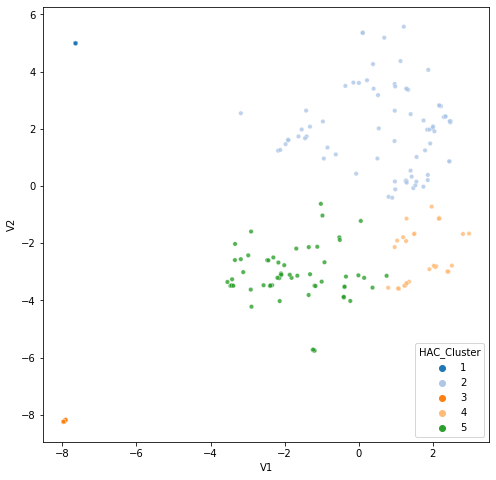

In [62]:
f,ax = plt.subplots(1,1,figsize=(8,8))
sns.scatterplot(data=selected, x='V1', y='V2', hue='HAC_Cluster', 
                palette=sns.color_palette('tab20')[:len(selected.HAC_Cluster.unique())],
                alpha=0.8, s=20, ax=ax);

In [ ]:
selected[selected.HAC_Cluster==3][['host_name','name','description']]

In [65]:
gdf = gpd.GeoDataFrame(selected, geometry=gpd.points_from_xy(selected.longitude, selected.latitude))

<AxesSubplot:>

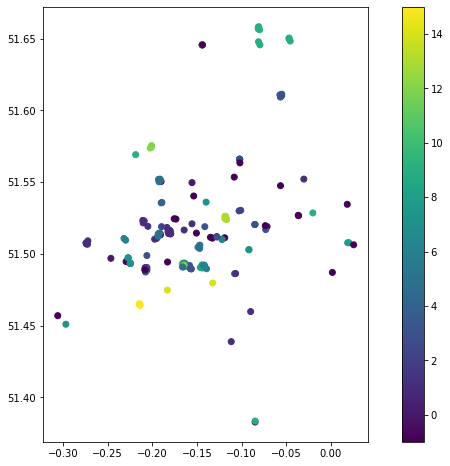

In [69]:
gdf.plot(column='dbscan', figsize=(12,8), legend=True)